In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class RotatedMNIST(Dataset):
    def __init__(self, root, train=True, digits=[1, 2]):
        self.mnist = torchvision.datasets.MNIST(root=root, train=train, download=True)
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.digits = digits
        self.angles = [30 * i for i in range(12)]  # Rotations: 0°, 30°, ..., 330°

        mask = np.isin(self.mnist.targets.numpy(), self.digits)
        self.data = self.mnist.data[mask]
        self.targets = self.mnist.targets[mask]

    def __len__(self):
        return len(self.data) * len(self.angles)

    def __getitem__(self, idx):
        img_idx = idx // len(self.angles)
        angle = self.angles[idx % len(self.angles)]
        img = Image.fromarray(self.data[img_idx].numpy(), mode='L').rotate(angle)
        return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=10, num_classes=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder with added capacity
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 28x28 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder with added capacity
        self.decoder_input = nn.Linear(latent_dim, 256)
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.Sigmoid()
        )

        # self.classifier = nn.Linear(latent_dim, num_classes)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.decoder_input(z))
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        # class_logits = self.classifier(z)
        # return recon_x, mu, logvar, z, class_logits
        return recon_x, mu, logvar, z

In [6]:
def loss_function(recon_x, x, mu, logvar, z, normalized_angle, class_logits=None, labels=None, beta=1.0, gamma=1.0, delta=1.0):
    batch_size = x.size(0)
    # Reconstruction loss
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum') / batch_size
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size
    # Regression loss for rotation
    MSE = F.mse_loss(z[:, 0], normalized_angle, reduction='mean')
    # CE = F.cross_entropy(class_logits, labels)
    
    return BCE + beta*KLD + gamma*MSE #+ delta*CE

In [7]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load datasets
dataset = RotatedMNIST(root='./data', train=True, digits=[1, 2])
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

angles = torch.tensor([30 * i for i in range(12)], dtype=torch.float)
mean_angle = angles.mean()
sd_angle = angles.std()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.07MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **Task 1**

In [9]:
# Initialize model and optimizer
# vae = VAE(latent_dim=32).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
# vae = nn.DataParallel(vae) 
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    for images, labels, angles in dataloader:
        images = images.to(device)
        angles = angles.to(device)
        labels = labels.to(device)
        normalized_angles = (angles - mean_angle) / sd_angle
        labels_mapped = labels - 1
        
        optimizer.zero_grad()
        # recon_x, mu, logvar, z, class_logits = vae(images)
        recon_x, mu, logvar, z = vae(images)
        # loss = loss_function(recon_x, images, mu, logvar, z, normalized_angles, class_logits, labels_mapped, beta=1.0, gamma=15.0, delta=0.5)
        loss = loss_function(recon_x, images, mu, logvar, z, normalized_angles, beta=1.0, gamma=12.5, delta=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [1/30], Loss: 84.2627


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [2/30], Loss: 83.7407


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [3/30], Loss: 83.3768


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [4/30], Loss: 83.0415


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [5/30], Loss: 82.7590


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [6/30], Loss: 82.4571


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [7/30], Loss: 82.2396


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [8/30], Loss: 81.9949


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [9/30], Loss: 81.7719


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [10/30], Loss: 81.6204


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [11/30], Loss: 81.4302


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [12/30], Loss: 81.2855


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [13/30], Loss: 81.1119


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [14/30], Loss: 80.9197


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [15/30], Loss: 80.8166


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [16/30], Loss: 80.6886


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [17/30], Loss: 80.5481


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [18/30], Loss: 80.4335


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [19/30], Loss: 80.2824


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [20/30], Loss: 80.1812


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [21/30], Loss: 80.0810


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [22/30], Loss: 80.0130


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [23/30], Loss: 79.8897


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [24/30], Loss: 79.7888


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [25/30], Loss: 79.6883


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [26/30], Loss: 79.5760


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [27/30], Loss: 79.5158


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [28/30], Loss: 79.4307


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [29/30], Loss: 79.3918


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

Epoch [30/30], Loss: 79.2906


In [8]:
# vae = VAE(latent_dim=32).to(device)
# vae.load_state_dict(torch.load("/kaggle/input/rot-sym-vae/pytorch/v2/2/vae3.pth"))

<ipython-input-8-9b80fd940072>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("/kaggle/input/rot-sym-vae/pytorch/v2/2/vae3.pth"))


<All keys matched successfully>

In [10]:
# torch.save(vae.state_dict(), "vae3_40.pth")

<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

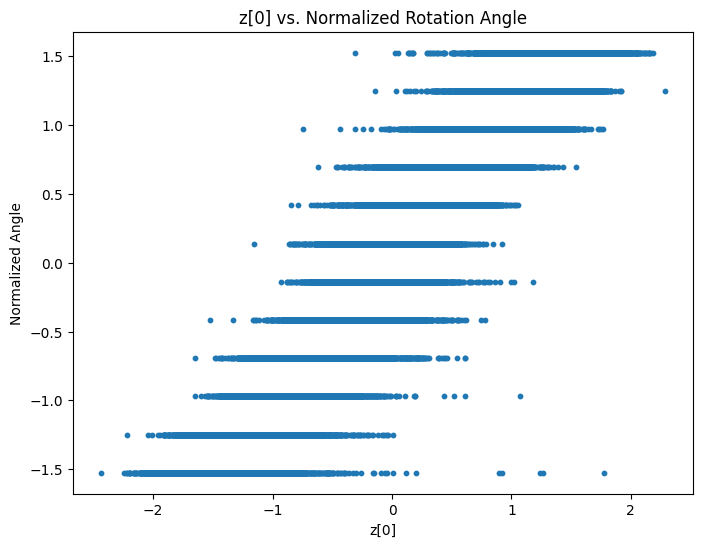

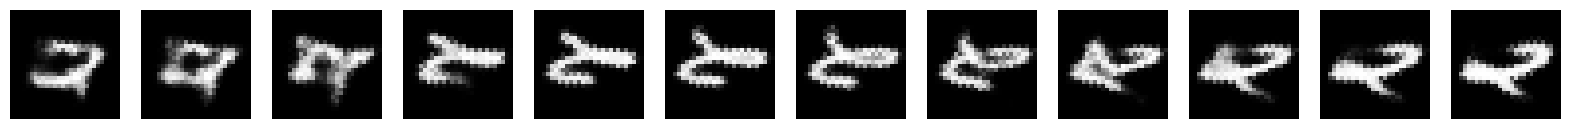

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Collect latent representations
vae.eval()
latent_vectors = []
angles_list = []
labels_list = []

with torch.no_grad():
    for images, labels, angles in dataloader:
        images = images.to(device)
        mu, _ = vae.encode(images)
        latent_vectors.append(mu.cpu().numpy())
        angles_list.append(angles.numpy())
        labels_list.append(labels.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
angles_list = np.concatenate(angles_list, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

# Check z[0] vs. normalized angles
# normalized_angles = (angles_list - mean_angle) / sd_angle
normalized_angles = (torch.tensor(angles_list) - mean_angle) / sd_angle
plt.figure(figsize=(8, 6))
plt.scatter(latent_vectors[:, 0], normalized_angles, s=10)
plt.xlabel('z[0]')
plt.ylabel('Normalized Angle')
plt.title('z[0] vs. Normalized Rotation Angle')
plt.show()

# Generate images by varying z[0]
with torch.no_grad():
    sample_mu = mu[0:1]  # Take one sample
    z = sample_mu.clone()
    z_range = torch.linspace(-2, 2, steps=12).to(device)  # Range for z[0]
    generated = []
    for z_val in z_range:
        z[0, 0] = z_val
        recon = vae.decode(z)
        generated.append(recon.cpu().numpy())
    generated = np.concatenate(generated, axis=0)

    fig, axes = plt.subplots(1, 12, figsize=(20, 2))
    for i, ax in enumerate(axes):
        ax.imshow(generated[i, 0], cmap='gray')
        ax.axis('off')
    plt.show()

<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

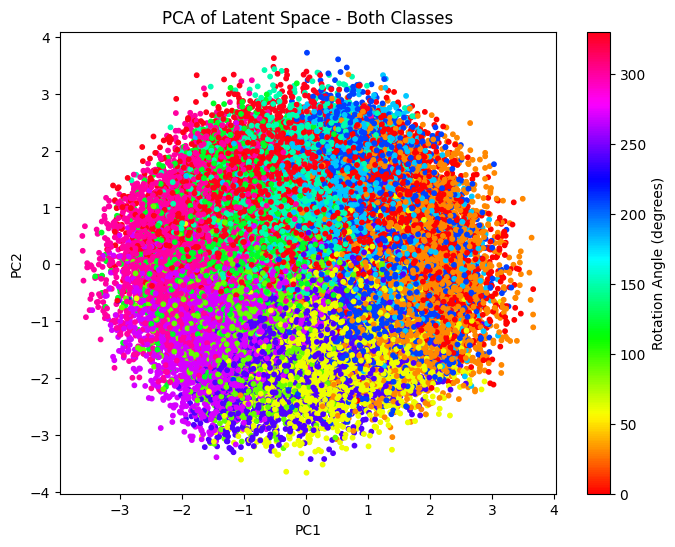

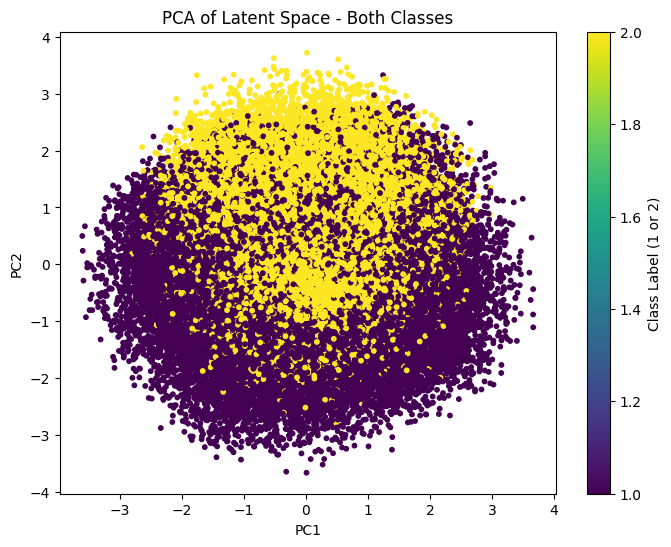

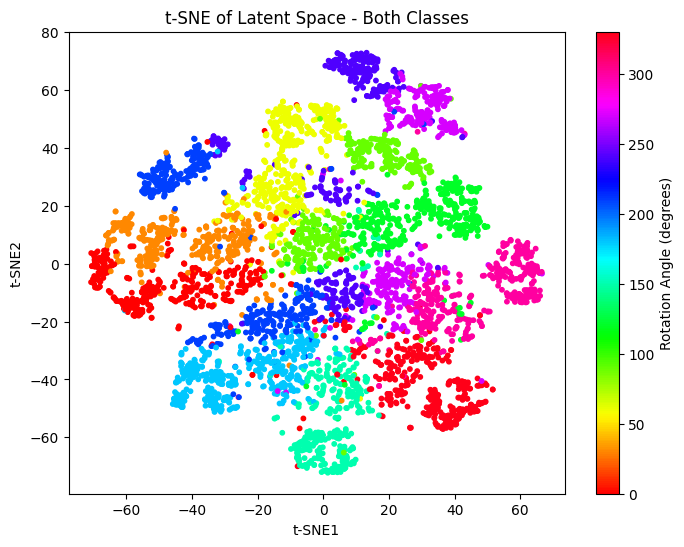

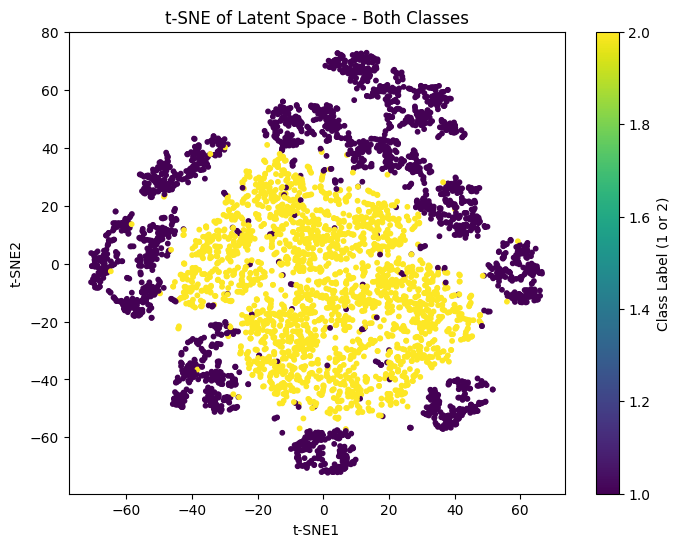

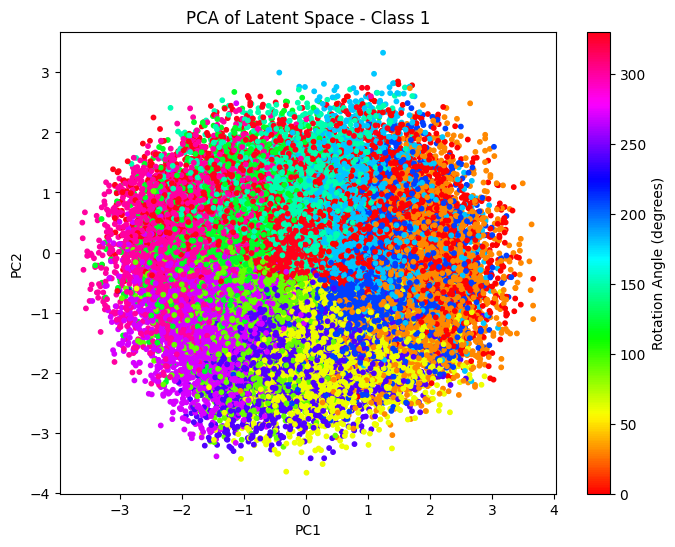

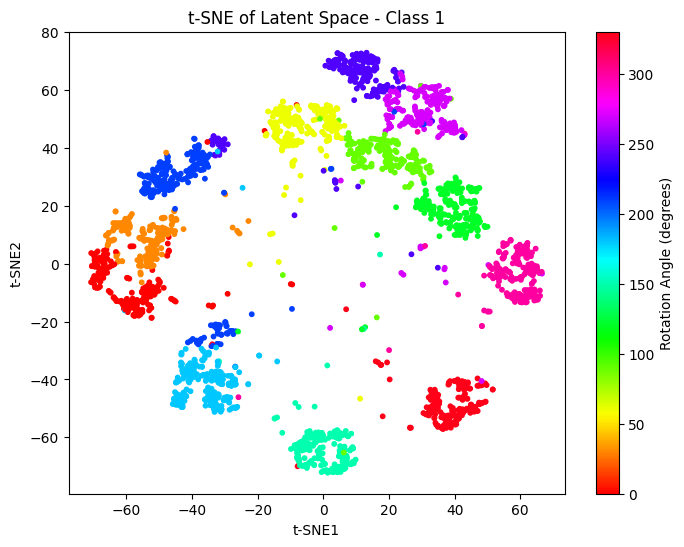

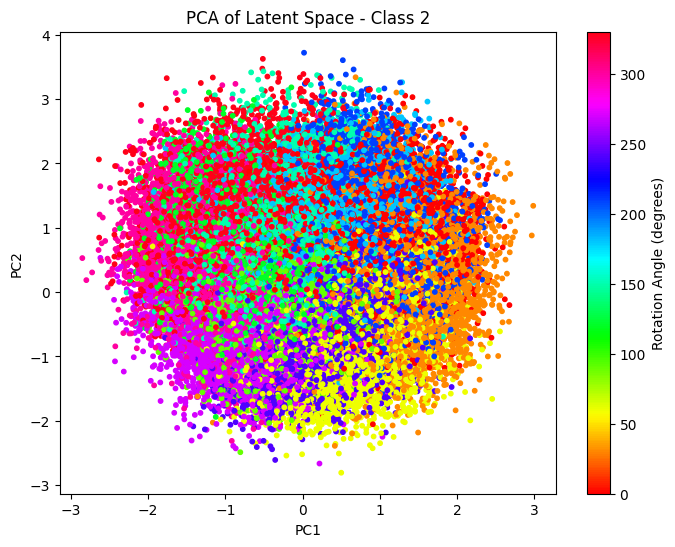

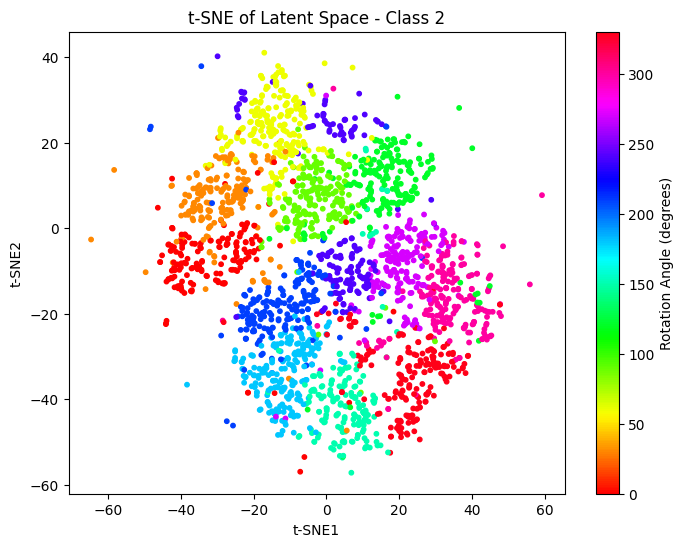

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Collect latent representations from the test set
vae.eval()
latent_vectors = []
angles_list = []
labels_list = []

with torch.no_grad():
    for images, labels, angles in dataloader:
        images = images.to(device)
        mu, _ = vae.encode(images)
        latent_vectors.append(mu.cpu().numpy())
        angles_list.append(angles.numpy())
        labels_list.append(labels.numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
angles_list = np.concatenate(angles_list, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

# PCA for both classes
pca = PCA(n_components=2)
latent_2d_pca = pca.fit_transform(latent_vectors)

# PCA: Both classes colored by angles
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1], c=angles_list, cmap='hsv', s=10)
plt.colorbar(scatter, label='Rotation Angle (degrees)')
plt.title('PCA of Latent Space - Both Classes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# PCA: Both classes colored by class labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1], c=labels_list, cmap='viridis', s=10)
plt.colorbar(scatter, label='Class Label (1 or 2)')
plt.title('PCA of Latent Space - Both Classes')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# t-SNE for both classes
subset_idx = np.random.choice(len(latent_vectors), 5000, replace=False)
tsne = TSNE(n_components=2, random_state=42)
latent_2d_tsne = tsne.fit_transform(latent_vectors[subset_idx])

# t-SNE: Both classes colored by angles
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=angles_list[subset_idx], cmap='hsv', s=10)
plt.colorbar(scatter, label='Rotation Angle (degrees)')
plt.title('t-SNE of Latent Space - Both Classes')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

# t-SNE: Both classes colored by class labels
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1], c=labels_list[subset_idx], cmap='viridis', s=10)
plt.colorbar(scatter, label='Class Label (1 or 2)')
plt.title('t-SNE of Latent Space - Both Classes')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.show()

# Plots for individual classes
for class_label in [1, 2]:
    mask = (labels_list == class_label)
    latent_2d_pca_class = latent_2d_pca[mask]
    
    # Filter angles_list for PCA plot using the mask directly 
    angles_class_pca = angles_list[mask]  

    mask_subset = mask[subset_idx]  
    latent_2d_tsne_class = latent_2d_tsne[mask_subset] 

    angles_class_tsne = angles_list[subset_idx][mask_subset] 

    # PCA for individual class
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d_pca_class[:, 0], latent_2d_pca_class[:, 1], 
                        c=angles_class_pca, cmap='hsv', s=10)
    plt.colorbar(scatter, label='Rotation Angle (degrees)')
    plt.title(f'PCA of Latent Space - Class {class_label}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

    # t-SNE for individual class (use angles_class_tsne as before)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d_tsne_class[:, 0], latent_2d_tsne_class[:, 1], 
                        c=angles_class_tsne, cmap='hsv', s=10)
    plt.colorbar(scatter, label='Rotation Angle (degrees)')
    plt.title(f't-SNE of Latent Space - Class {class_label}')
    plt.xlabel('t-SNE1')
    plt.ylabel('t-SNE2')
    plt.show()

# Task 2

In [13]:
class RotationMLP(nn.Module):
    def __init__(self, latent_dim=16):
        super(RotationMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, z):
        return self.model(z)

# Dataset for paired latent vectors
class LatentRotationDataset(Dataset):
    def __init__(self, vae, rot_mnist_dataset):
        self.vae = vae
        self.rot_mnist_dataset = rot_mnist_dataset
        self.num_images = len(rot_mnist_dataset.data)
        self.angles = rot_mnist_dataset.angles

    def __len__(self):
        return self.num_images * (len(self.angles) - 1)  # Pairs up to 330° -> 0° excluded

    def __getitem__(self, idx):
        img_idx = idx // (len(self.angles) - 1)
        angle_idx = idx % (len(self.angles) - 1)
        angle = self.angles[angle_idx]
        next_angle = self.angles[angle_idx + 1]

        # Get original and rotated images
        img_orig, _, _ = self.rot_mnist_dataset[img_idx * len(self.angles) + angle_idx]
        img_rot, _, _ = self.rot_mnist_dataset[img_idx * len(self.angles) + angle_idx + 1]

        # Encode to latent space
        with torch.no_grad():
            z_orig, _ = self.vae.encode(img_orig.unsqueeze(0).to(device))
            z_rot, _ = self.vae.encode(img_rot.unsqueeze(0).to(device))

        return z_orig.squeeze(0), z_rot.squeeze(0)

# Training the MLP
def train_mlp(mlp, dataloader, vae, num_epochs=50, learning_rate=1e-3):
    optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    mlp.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for z_orig, z_rot in dataloader:
            z_orig, z_rot = z_orig.to(device), z_rot.to(device)
            optimizer.zero_grad()
            z_pred = mlp(z_orig)
            loss = criterion(z_pred, z_rot)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")
    return mlp

# Main execution
if __name__ == "__main__":
    # Load dataset
    rot_mnist_dataset = RotatedMNIST(root='./data', train=True)
    dataloader_mnist = DataLoader(rot_mnist_dataset, batch_size=128, shuffle=True, num_workers=2)

    # Load pre-trained ConvVAE
    latent_dim = 32
    # vae = ConvVAE(latent_dim=latent_dim).to(device)
    # vae.load_state_dict(torch.load("/kaggle/working/conv_vae_mnist.pth"))
    vae.eval()

    # Prepare latent rotation dataset
    latent_dataset = LatentRotationDataset(vae, rot_mnist_dataset)
    latent_dataloader = DataLoader(latent_dataset, batch_size=128, shuffle=True)

    mlp = RotationMLP(latent_dim=latent_dim).to(device)
    # trained_mlp = mlp
    # trained_mlp.load_state_dict(torch.load("/content/rotation_mlp.pth"))
    trained_mlp = train_mlp(mlp, latent_dataloader, vae, num_epochs=10)
    torch.save(trained_mlp.state_dict(), "rotation_mlp_vae3_40.pth")

<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)


Epoch 1/10, Loss: 0.036196
Epoch 2/10, Loss: 0.019140
Epoch 3/10, Loss: 0.016505
Epoch 4/10, Loss: 0.015205
Epoch 5/10, Loss: 0.014361
Epoch 6/10, Loss: 0.013730
Epoch 7/10, Loss: 0.013277
Epoch 8/10, Loss: 0.012938
Epoch 9/10, Loss: 0.012620
Epoch 10/10, Loss: 0.012414


In [14]:
vae.eval()
trained_mlp.eval()
with torch.no_grad():
    sample, _, _ = next(iter(dataloader_mnist))
    sample = sample[:8].to(device)
    z_orig, _ = vae.encode(sample)
    z_pred = trained_mlp(z_orig)
    recon_orig = vae.decode(z_orig)
    recon_rot = vae.decode(z_pred)
    comparison = torch.cat([sample, recon_orig, recon_rot])
    save_image(comparison, "rotation_test_vae3_40.png")  # Original, Reconstructed, Predicted Rotated

<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)


# Task 3

In [15]:
class LatentDataset(Dataset):
    def __init__(self, vae, rot_mnist_dataset):
        self.vae = vae
        self.rot_mnist_dataset = rot_mnist_dataset
        self.data = []
        self.labels = []
        with torch.no_grad():
            for img, label, _ in rot_mnist_dataset:
                mu, _ = vae.encode(img.unsqueeze(0).to(device))
                self.data.append(mu.squeeze(0).cpu())
                self.labels.append(label - 1)  # Map 1->0, 2->1
        self.data = torch.stack(self.data)
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [16]:
class Oracle(nn.Module): #simple NN for transforms
    def __init__(self, latent_dim=16, num_classes=2):
        super(Oracle, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, z):
        return self.model(z)

In [17]:
class SymmetryGenerator(nn.Module): #Symmetry Modules
    def __init__(self, latent_dim=16):
        super(SymmetryGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
    def forward(self, z):
        return self.model(z)

In [18]:
def train_classifier(classifier, dataloader, num_epochs=20, learning_rate=1e-3):
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    classifier.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for z, label in dataloader:
            z, label = z.to(device), label.to(device)
            optimizer.zero_grad()
            logits = classifier(z)
            loss = criterion(logits, label)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f"Classifier Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(dataloader):.4f}")
    return classifier

In [19]:
N_g = 3  # Number of symmetries (e.g., rotation and thickening)
generators = [SymmetryGenerator(latent_dim=32).to(device) for _ in range(N_g)]

# Training function
def train_symmetry_generators(generators, classifier, dataloader, num_epochs=50,
                              learning_rate=1e-3, epsilon=0.05, h_norm=1.2, h_ortho=1.8):
    optimizers = [optim.Adam(gen.parameters(), lr=learning_rate) for gen in generators]
    classifier.eval()  # Freeze the classifier

    for epoch in range(num_epochs):
        total_inv_loss = total_norm_loss = total_ortho_loss = 0
        for z, _ in dataloader:  # z is latent vectors from VAE
            z = z.to(device)
            # Zero gradients
            for opt in optimizers:
                opt.zero_grad()

            # Compute generator outputs
            g_z_list = [gen(z) for gen in generators]
            z_prime_list = [z + epsilon * g_z for g_z in g_z_list]

            # Invariance Loss
            psi_z = classifier(z)
            inv_loss = 0
            for z_prime in z_prime_list:
                psi_z_prime = classifier(z_prime)
                inv_loss += torch.mean((psi_z_prime - psi_z) ** 2) / (epsilon ** 2)
            inv_loss /= N_g

            # Normalization Loss
            norm_loss = 0
            for g_z in g_z_list:
                norms = torch.norm(g_z, dim=1)
                norm_loss += torch.mean((norms - 1) ** 2) + torch.mean((norms - norms.mean()) ** 2)
            norm_loss /= N_g

            # Orthogonality Loss
            ortho_loss = 0
            for i in range(N_g):
                for j in range(i + 1, N_g):
                    dot_products = (g_z_list[i] * g_z_list[j]).sum(dim=1)
                    ortho_loss += torch.mean(dot_products ** 2)

            # Total Loss
            loss = inv_loss + h_norm * norm_loss + h_ortho * ortho_loss
            loss.backward()
            for opt in optimizers:
                opt.step()

            total_inv_loss += inv_loss.item()
            total_norm_loss += norm_loss.item()
            total_ortho_loss += ortho_loss.item()

        avg_inv = total_inv_loss / len(dataloader)
        avg_norm = total_norm_loss / len(dataloader)
        avg_ortho = total_ortho_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Inv: {avg_inv:.6f}, Norm: {avg_norm:.6f}, Ortho: {avg_ortho:.6f}")

    return generators

In [20]:
if __name__ == "__main__":
    # Load dataset
    dataset = RotatedMNIST(root='./data', train=True)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

    # Load pre-trained ConvVAE
    latent_dim = 32
    # vae = ConvVAE(latent_dim=latent_dim).to(device)classifier = Oracle(latent_dim=32).to(device)
    # trained_classifier = train_classifier(classifier, latent_dataloader, num_epochs=20)
    # torch.save(trained_classifier.state_dict(), "classifier.pth")
    vae.eval()

    # Create latent dataset
    latent_dataset = LatentDataset(vae, dataset)
    latent_dataloader = DataLoader(latent_dataset, batch_size=128, shuffle=True, num_workers=4)

<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)


In [21]:
classifier = Oracle(latent_dim=32).to(device)
trained_classifier = train_classifier(classifier, latent_dataloader, num_epochs=25)
torch.save(trained_classifier.state_dict(), "classifier_25.pth")

Classifier Epoch 1/25, Loss: 0.0582
Classifier Epoch 2/25, Loss: 0.0228
Classifier Epoch 3/25, Loss: 0.0193
Classifier Epoch 4/25, Loss: 0.0170
Classifier Epoch 5/25, Loss: 0.0153
Classifier Epoch 6/25, Loss: 0.0142
Classifier Epoch 7/25, Loss: 0.0134
Classifier Epoch 8/25, Loss: 0.0126
Classifier Epoch 9/25, Loss: 0.0116
Classifier Epoch 10/25, Loss: 0.0114
Classifier Epoch 11/25, Loss: 0.0109
Classifier Epoch 12/25, Loss: 0.0103
Classifier Epoch 13/25, Loss: 0.0100
Classifier Epoch 14/25, Loss: 0.0098
Classifier Epoch 15/25, Loss: 0.0095
Classifier Epoch 16/25, Loss: 0.0090
Classifier Epoch 17/25, Loss: 0.0086
Classifier Epoch 18/25, Loss: 0.0086
Classifier Epoch 19/25, Loss: 0.0084
Classifier Epoch 20/25, Loss: 0.0080
Classifier Epoch 21/25, Loss: 0.0077
Classifier Epoch 22/25, Loss: 0.0074
Classifier Epoch 23/25, Loss: 0.0074
Classifier Epoch 24/25, Loss: 0.0071
Classifier Epoch 25/25, Loss: 0.0069


In [22]:
trained_generators = train_symmetry_generators(generators, trained_classifier, latent_dataloader, num_epochs=25)
torch.save(trained_generators[0].state_dict(), "generators0_25.pth")
torch.save(trained_generators[1].state_dict(), "generators1_25.pth")
torch.save(trained_generators[2].state_dict(), "generators2_25.pth")

Epoch 1/25, Inv: 0.470758, Norm: 0.070712, Ortho: 0.002906
Epoch 2/25, Inv: 0.080648, Norm: 0.006773, Ortho: 0.000399
Epoch 3/25, Inv: 0.051138, Norm: 0.002954, Ortho: 0.000227
Epoch 4/25, Inv: 0.040160, Norm: 0.001784, Ortho: 0.000150
Epoch 5/25, Inv: 0.033110, Norm: 0.001250, Ortho: 0.000112
Epoch 6/25, Inv: 0.029783, Norm: 0.000998, Ortho: 0.000093
Epoch 7/25, Inv: 0.026851, Norm: 0.000810, Ortho: 0.000080
Epoch 8/25, Inv: 0.025212, Norm: 0.000727, Ortho: 0.000070
Epoch 9/25, Inv: 0.023553, Norm: 0.000645, Ortho: 0.000066
Epoch 10/25, Inv: 0.022363, Norm: 0.000593, Ortho: 0.000061
Epoch 11/25, Inv: 0.021423, Norm: 0.000546, Ortho: 0.000057
Epoch 12/25, Inv: 0.020072, Norm: 0.000493, Ortho: 0.000056
Epoch 13/25, Inv: 0.019222, Norm: 0.000454, Ortho: 0.000053
Epoch 14/25, Inv: 0.019121, Norm: 0.000438, Ortho: 0.000052
Epoch 15/25, Inv: 0.017624, Norm: 0.000391, Ortho: 0.000050
Epoch 16/25, Inv: 0.017340, Norm: 0.000375, Ortho: 0.000050
Epoch 17/25, Inv: 0.016908, Norm: 0.000363, Ortho

In [47]:
# trained_classifier = Oracle(latent_dim=32).to(device)
# trained_classifier.load_state_dict(torch.load("/kaggle/working/classifier_25.pth"))

# trained_generators = generators
# trained_generators[0].load_state_dict(torch.load("/kaggle/working/generators0_25.pth"))
# trained_generators[1].load_state_dict(torch.load("/kaggle/working/generators1_25.pth"))
trained_generators[2].load_state_dict(torch.load("/kaggle/input/rot-sym-vae/pytorch/v2/2/generators2.pth"))

<ipython-input-47-9ecb54a29e9e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_generators[2].load_state_dict(torch.load("/kaggle/input/rot-sym-vae/pytorch/v2/2/gen

<All keys matched successfully>

Sample 64603, Original Label: 1, Predicted: 0


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)


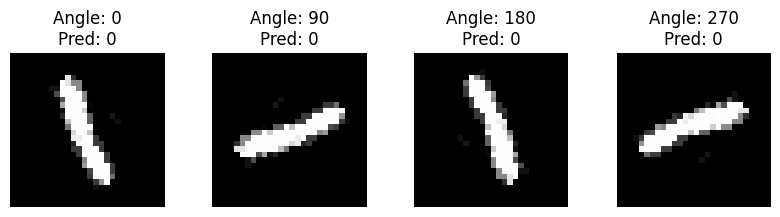

Sample 32139, Original Label: 1, Predicted: 0


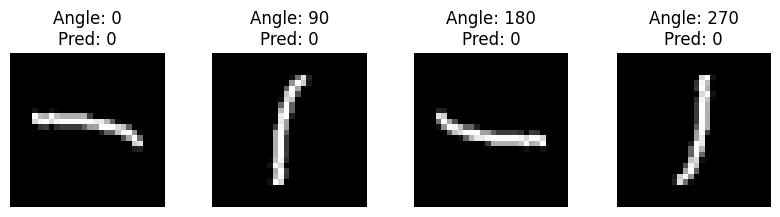

Sample 18744, Original Label: 2, Predicted: 1


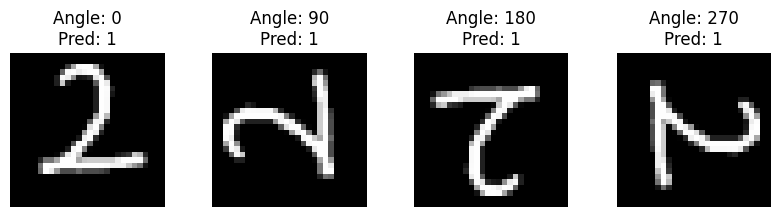

Sample 46469, Original Label: 2, Predicted: 1


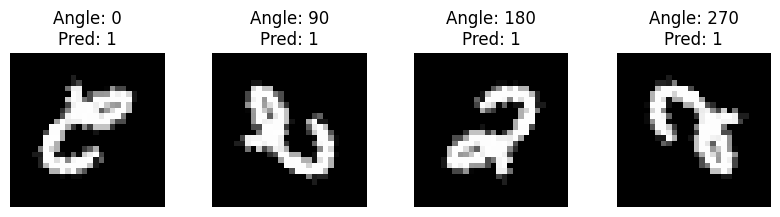

Sample 12489, Original Label: 1, Predicted: 0


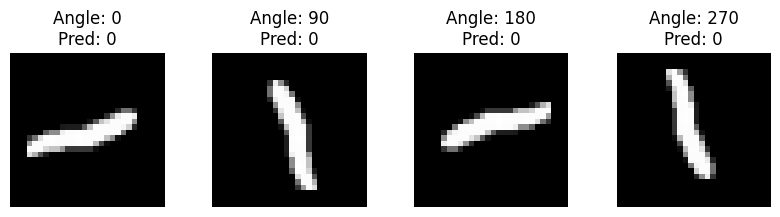

In [41]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def check_classifier_invariance(classifier, vae, dataset, device, num_samples=5):
    classifier.eval()
    vae.eval()
    sample_indices = torch.randperm(len(dataset))[:num_samples].tolist()

    angles = [0, 90, 180, 270]  # Test rotations
    for idx in sample_indices:
        img, label, _ = dataset[idx]
        img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            mu, _ = vae.encode(img)
            z = mu
            logits_orig = classifier(z)
            pred_orig = logits_orig.argmax(dim=1).item()

        print(f"Sample {idx}, Original Label: {label}, Predicted: {pred_orig}")

        plt.figure(figsize=(10, 2))
        for i, angle in enumerate(angles):
            rotated_img = transforms.functional.rotate(img, angle)
            with torch.no_grad():
                mu_rot, _ = vae.encode(rotated_img)
                z_rot = mu_rot
                logits_rot = classifier(z_rot)
                pred_rot = logits_rot.argmax(dim=1).item()

            plt.subplot(1, len(angles), i + 1)
            plt.imshow(rotated_img.squeeze().cpu(), cmap='gray')
            plt.title(f"Angle: {angle}\nPred: {pred_rot}")
            plt.axis('off')

        plt.show()

check_classifier_invariance(trained_classifier, vae, dataset, device)

<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)


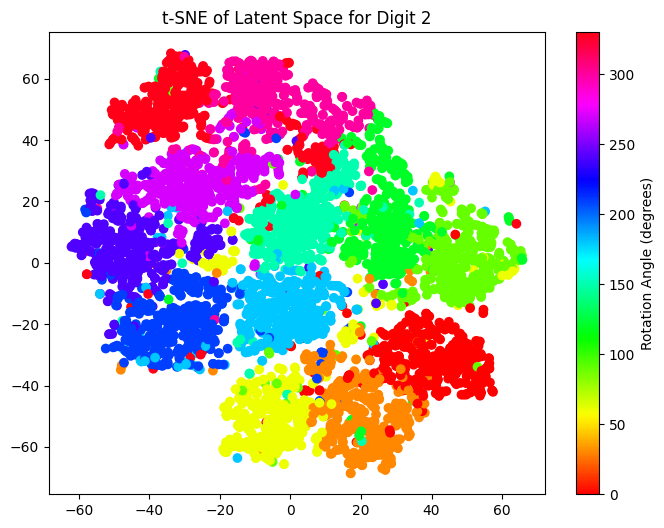

In [42]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def check_latent_space_rotation(vae, dataset, device, digit=1, num_samples=5000):
    vae.eval()
    angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
    latent_vectors = []
    angle_labels = []

    # Collect latent vectors for a specific digit at different angles
    count = 0
    for i in range(len(dataset)):
        img, label, angle = dataset[i]
        if label == digit and angle in angles and count < num_samples:
            img = img.unsqueeze(0).to(device)
            with torch.no_grad():
                mu, _ = vae.encode(img)
                latent_vectors.append(mu.squeeze().cpu())
                angle_labels.append(angle)
            count += 1
        if count >= num_samples:
            break

    latent_vectors = torch.stack(latent_vectors).numpy()
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=angle_labels, cmap='hsv')
    plt.colorbar(scatter, label='Rotation Angle (degrees)')
    plt.title(f't-SNE of Latent Space for Digit {digit}')
    plt.show()

check_latent_space_rotation(vae, dataset, device, digit=2)

In [43]:
import torch

def check_generator_magnitude(generators, dataloader, device):
    for gen in generators:
        gen.eval()

    with torch.no_grad():
        for batch_idx, (z, _) in enumerate(dataloader):
            z = z.to(device)
            for i, gen in enumerate(generators):
                g_z = gen(z)
                norms = torch.norm(g_z, dim=1)
                print(f"Batch {batch_idx}, Generator {i}: Mean Norm = {norms.mean().item():.4f}, Std = {norms.std().item():.4f}")
            if batch_idx >= 2:  # Check a few batches
                break

check_generator_magnitude(trained_generators, latent_dataloader, device)

Batch 0, Generator 0: Mean Norm = 0.9900, Std = 0.0096
Batch 0, Generator 1: Mean Norm = 0.9928, Std = 0.0070
Batch 0, Generator 2: Mean Norm = 0.9920, Std = 0.0084
Batch 1, Generator 0: Mean Norm = 0.9899, Std = 0.0099
Batch 1, Generator 1: Mean Norm = 0.9931, Std = 0.0069
Batch 1, Generator 2: Mean Norm = 0.9912, Std = 0.0078
Batch 2, Generator 0: Mean Norm = 0.9900, Std = 0.0082
Batch 2, Generator 1: Mean Norm = 0.9930, Std = 0.0072
Batch 2, Generator 2: Mean Norm = 0.9920, Std = 0.0093


In [44]:
import torch

def check_generator_orthogonality(generators, dataloader, device):
    for gen in generators:
        gen.eval()

    with torch.no_grad():
        for batch_idx, (z, _) in enumerate(dataloader):
            z = z.to(device)
            g_z_list = [gen(z) for gen in generators]
            for i in range(len(generators)):
                for j in range(i + 1, len(generators)):
                    dot_products = (g_z_list[i] * g_z_list[j]).sum(dim=1)
                    mean_dot = dot_products.mean().item()
                    print(f"Batch {batch_idx}, Generators {i} vs {j}: Mean Dot Product = {mean_dot:.4f}")
            if batch_idx >= 2:
                break

check_generator_orthogonality(trained_generators, latent_dataloader, device)

Batch 0, Generators 0 vs 1: Mean Dot Product = -0.0022
Batch 0, Generators 0 vs 2: Mean Dot Product = 0.0019
Batch 0, Generators 1 vs 2: Mean Dot Product = -0.0002
Batch 1, Generators 0 vs 1: Mean Dot Product = -0.0026
Batch 1, Generators 0 vs 2: Mean Dot Product = 0.0021
Batch 1, Generators 1 vs 2: Mean Dot Product = -0.0007
Batch 2, Generators 0 vs 1: Mean Dot Product = -0.0022
Batch 2, Generators 0 vs 2: Mean Dot Product = 0.0018
Batch 2, Generators 1 vs 2: Mean Dot Product = -0.0004


<ipython-input-4-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)


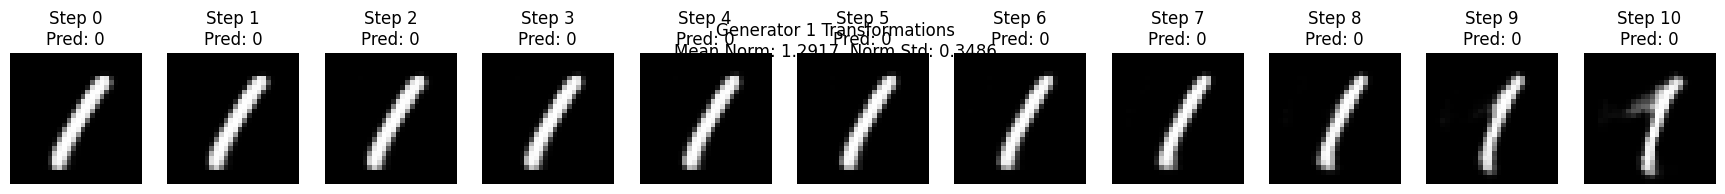

Generator 1 Norms: ['0.9906', '0.9849', '0.9846', '1.0338', '1.1155', '1.2345', '1.3628', '1.5075', '1.7195', '1.9837']
Generator 1: Classifier predictions are consistent (Label: 0)


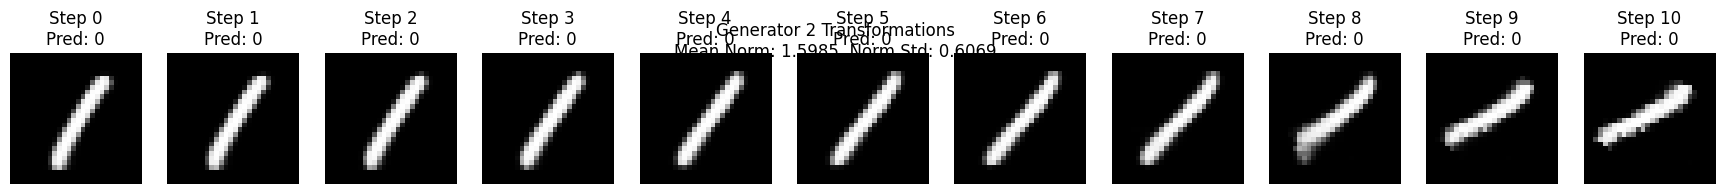

Generator 2 Norms: ['0.9840', '1.0002', '1.0607', '1.1904', '1.3519', '1.5347', '1.7558', '2.0250', '2.3479', '2.7347']
Generator 2: Classifier predictions are consistent (Label: 0)


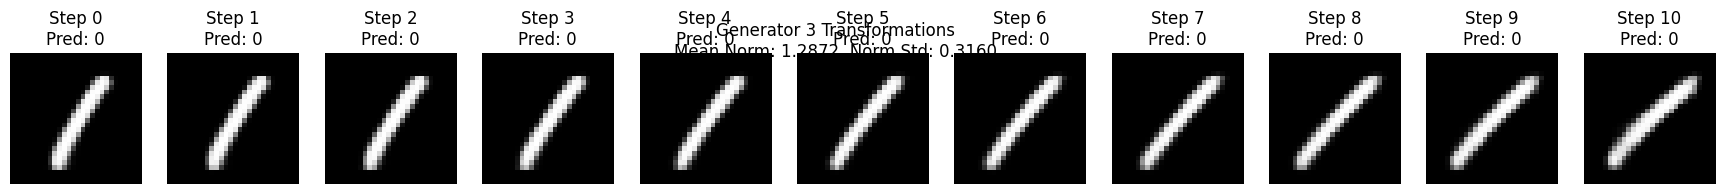

Generator 3 Norms: ['0.9857', '0.9833', '1.0098', '1.0505', '1.1349', '1.2540', '1.3809', '1.5210', '1.6828', '1.8690']
Generator 3: Classifier predictions are consistent (Label: 0)


In [50]:
import torch
import matplotlib.pyplot as plt

def visualize_all_symmetries(vae, classifier, generators, z_start, num_steps=10, epsilon=0.01):
    """
    Parameters:
    - vae: Trained VAE model with encode and decode methods.
    - classifier: Trained classifier (oracle) that predicts digit labels from latent vectors.
    - generators: List of trained symmetry generators.
    - z_start: Starting latent vector (tensor of shape [1, latent_dim]).
    - num_steps: Number of transformation steps to visualize.
    - epsilon: Step size for applying the transformation.
    """
    vae.eval()
    classifier.eval()
    for gen in generators:
        gen.eval()

    with torch.no_grad():
        orig_img = vae.decode(z_start).squeeze().cpu()
        orig_logits = classifier(z_start)
        orig_pred = orig_logits.argmax(dim=1).item()

    # Visualize transformations for each generator
    for gen_idx, generator in enumerate(generators):
        z = z_start.clone().detach()
        images = [orig_img]  # Start with the original image
        norms = []
        predictions = [orig_pred]

        with torch.no_grad():
            for step in range(num_steps):
                g_z = generator(z)
                norm = torch.norm(g_z).item()
                norms.append(norm)
                z = z + epsilon * g_z
                recon = vae.decode(z).squeeze().cpu()
                images.append(recon)

                # Check classifier prediction
                logits = classifier(z)
                pred = logits.argmax(dim=1).item()
                predictions.append(pred)

        # Plot the sequence of images
        fig, axes = plt.subplots(1, num_steps + 1, figsize=(22, 2))
        for i, (img, pred) in enumerate(zip(images, predictions)):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'Step {i}\nPred: {pred}')
            axes[i].axis('off')
        plt.suptitle(f'Generator {gen_idx + 1} Transformations\n'
                     f'Mean Norm: {sum(norms)/len(norms):.4f}, '
                     f'Norm Std: {torch.std(torch.tensor(norms)):.4f}')
        plt.show()

        # Print norms for this generator
        print(f"Generator {gen_idx + 1} Norms: {[f'{n:.4f}' for n in norms]}")

        # Check if predictions are consistent
        if all(pred == orig_pred for pred in predictions):
            print(f"Generator {gen_idx + 1}: Classifier predictions are consistent (Label: {orig_pred})")
        else:
            print(f"Generator {gen_idx + 1}: Classifier predictions vary: {predictions}")

sample_idx = 0  
img, label, _ = dataset[sample_idx]
img = img.unsqueeze(0).to(device)
with torch.no_grad():
    mu, _ = vae.encode(img)
    z_start = mu
visualize_all_symmetries(vae, trained_classifier, trained_generators, z_start, num_steps=10, epsilon=0.45)

<ipython-input-2-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)


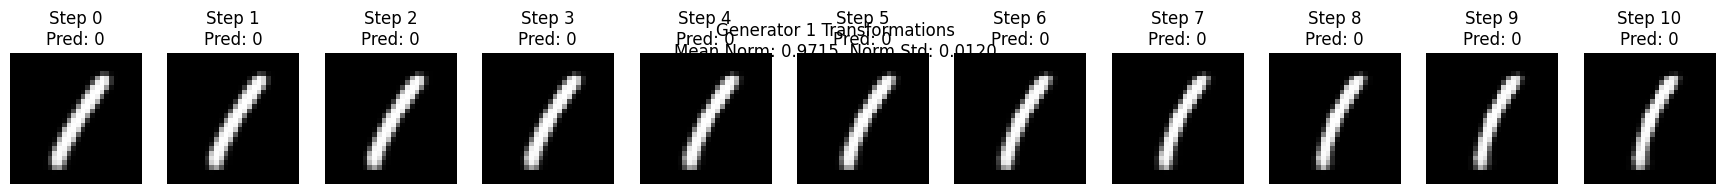

Generator 1 Norms: ['0.9868', '0.9698', '0.9663', '0.9593', '0.9576', '0.9611', '0.9675', '0.9728', '0.9809', '0.9931']
Generator 1: Classifier predictions are consistent (Label: 0)


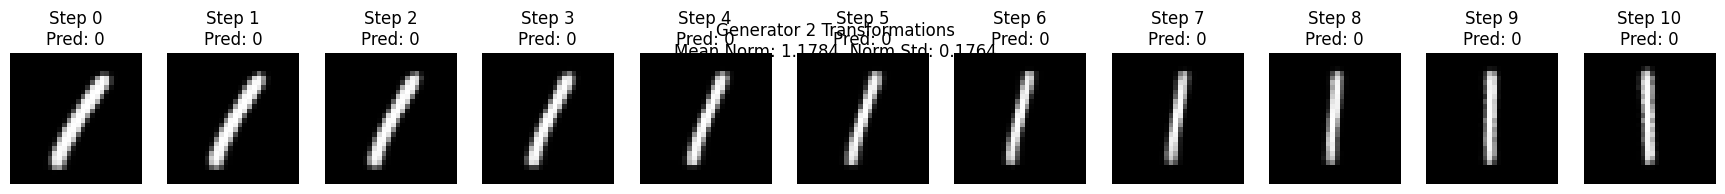

Generator 2 Norms: ['0.9829', '0.9930', '1.0169', '1.0688', '1.1195', '1.1749', '1.2326', '1.3059', '1.3958', '1.4935']
Generator 2: Classifier predictions are consistent (Label: 0)


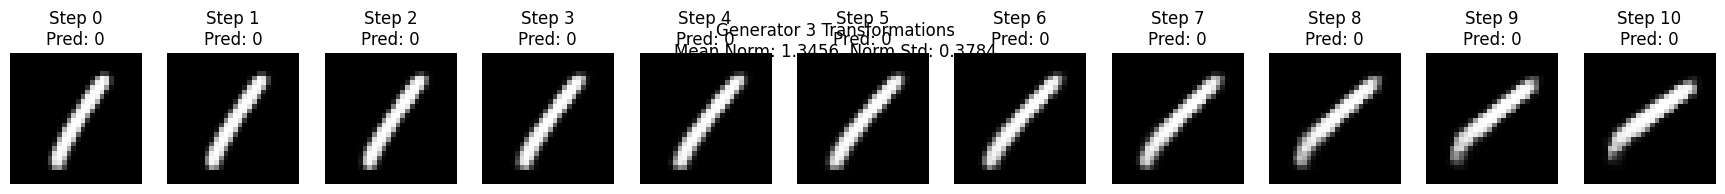

Generator 3 Norms: ['0.9965', '0.9878', '1.0091', '1.0580', '1.1609', '1.3010', '1.4512', '1.6229', '1.8211', '2.0474']
Generator 3: Classifier predictions are consistent (Label: 0)


In [17]:
import torch
import matplotlib.pyplot as plt

def visualize_all_symmetries(vae, classifier, generators, z_start, num_steps=10, epsilon=0.01):
    """
    Parameters:
    - vae: Trained VAE model with encode and decode methods.
    - classifier: Trained classifier (oracle) that predicts digit labels from latent vectors.
    - generators: List of trained symmetry generators.
    - z_start: Starting latent vector (tensor of shape [1, latent_dim]).
    - num_steps: Number of transformation steps to visualize.
    - epsilon: Step size for applying the transformation.
    """
    vae.eval()
    classifier.eval()
    for gen in generators:
        gen.eval()

    # Get the original image and its predicted label
    with torch.no_grad():
        orig_img = vae.decode(z_start).squeeze().cpu()
        orig_logits = classifier(z_start)
        orig_pred = orig_logits.argmax(dim=1).item()

    # Visualize transformations for each generator
    for gen_idx, generator in enumerate(generators):
        z = z_start.clone().detach()
        images = [orig_img]  # Start with the original image
        norms = []
        predictions = [orig_pred]

        with torch.no_grad():
            for step in range(num_steps):
                g_z = generator(z)
                norm = torch.norm(g_z).item()
                norms.append(norm)
                z = z + epsilon * g_z
                recon = vae.decode(z).squeeze().cpu()
                images.append(recon)

                # Check classifier prediction
                logits = classifier(z)
                pred = logits.argmax(dim=1).item()
                predictions.append(pred)

        # Plot the sequence of images
        fig, axes = plt.subplots(1, num_steps + 1, figsize=(22, 2))
        for i, (img, pred) in enumerate(zip(images, predictions)):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f'Step {i}\nPred: {pred}')
            axes[i].axis('off')
        plt.suptitle(f'Generator {gen_idx + 1} Transformations\n'
                     f'Mean Norm: {sum(norms)/len(norms):.4f}, '
                     f'Norm Std: {torch.std(torch.tensor(norms)):.4f}')
        plt.show()

        # Print norms for this generator
        print(f"Generator {gen_idx + 1} Norms: {[f'{n:.4f}' for n in norms]}")

        # Check if predictions are consistent
        if all(pred == orig_pred for pred in predictions):
            print(f"Generator {gen_idx + 1}: Classifier predictions are consistent (Label: {orig_pred})")
        else:
            print(f"Generator {gen_idx + 1}: Classifier predictions vary: {predictions}")

sample_idx = 0  # Choose a sample to visualize
img, label, _ = dataset[sample_idx]
img = img.unsqueeze(0).to(device)
with torch.no_grad():
    mu, _ = vae.encode(img)
    z_start = mu
visualize_all_symmetries(vae, trained_classifier, trained_generators, z_start, num_steps=10, epsilon=0.5)

# Bonus Task

In [33]:
import torch.nn as nn

class InvariantOracle(nn.Module):
    def __init__(self, latent_dim=16, num_classes=2):
        super(InvariantOracle, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, z):
        return self.model(z)

# Initialize
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device ="cpu"
invariant_oracle = InvariantOracle(latent_dim=32, num_classes=2).to(device)
torch.cuda.is_available()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [28]:
import torch.optim as optim
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
gen_rot = trained_generators[1]

optimizer = optim.Adam(invariant_oracle.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
gen_rot.eval()  # Freeze the rotation generator
vae.eval()  # Freeze the VAE
varepsilon = 0.01  # Step size for symmetry flow
lambda_inv = 1.0  # Weight for invariance loss
num_epochs = 20
batch_size = 256

invariant_oracle.train()
for epoch in range(num_epochs):
    for batch_idx, (x, y, _) in enumerate(dataloader):
        print("x shape:", x.shape, "y shape:", y.shape)
        print("x type:", x.dtype, "y type:", y.dtype)
        print("y values:", y.unique())
        print("x device:", x.device, "y device:", y.device)
        x, y = x.to(device), y.to(device)
        
        # Encode to latent space
        with torch.no_grad():
            mu, logvar = vae.encode(x)
            z = vae.reparameterize(mu, logvar)
        
        optimizer.zero_grad()
        
        # Forward pass on original z
        logits_z = invariant_oracle(z)
        
        # Generate rotated z'
        with torch.no_grad():
            G_z = gen_rot(z)
            z_prime = z + varepsilon * G_z
        
        # Forward pass on rotated z'
        logits_z_prime = invariant_oracle(z_prime)
        # Compute losses
        L_class = criterion(logits_z, y)
        L_inv = torch.mean((logits_z - logits_z_prime) ** 2)
        loss = L_class + lambda_inv * L_inv
        
        # Backpropagate and optimize
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

invariant_oracle.eval()

<ipython-input-2-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-2-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=torch.float)
<ipython-input-2-d0b52fe130d0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.transform(img), torch.tensor(self.targets[img_idx]), torch.tensor(angle, dtype=to

x shape: torch.Size([128, 1, 28, 28]) y shape: torch.Size([128])
x type: torch.float32 y type: torch.int64
y values: tensor([1, 2])
x device: cpu y device: cpu


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
def test_invariance(oracle, vae, test_loader, gen_rot, epsilon=0.01):
    oracle.eval()
    vae.eval()
    gen_rot.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            mu, logvar = vae.encode(x)
            z = vae.reparameterize(mu, logvar)
            
            # Predict on original z
            logits_z = oracle(z)
            pred_z = torch.argmax(logits_z, dim=1)
            
            # Predict on rotated z'
            G_z = gen_rot(z)
            z_prime = z + epsilon * G_z
            logits_z_prime = oracle(z_prime)
            pred_z_prime = torch.argmax(logits_z_prime, dim=1)
            
            correct += (pred_z == y).sum().item() + (pred_z_prime == y).sum().item()
            total += 2 * y.size(0)  # Count both original and rotated predictions
    
    accuracy = correct / total
    print(f"Accuracy on original and rotated latent vectors: {accuracy:.4f}")

test_invariance(invariant_oracle, vae, test_loader, gen_rot)